In [1]:
# =========================
# Libraries
# =========================

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
import time
import emcee
from multiprocessing import pool
import multiprocessing as mp
from getdist import MCSamples, plots
import matplotlib.pyplot as plt

In [2]:
# =========================
# Loading SNe Ia data (Pantheon+SH0ES)
# =========================

# Path
sne_dat_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/SNe/Pantheon+SH0ES.dat"
sne_cov_path = "/home/brunowesley/projetos/MCMC-cosmo/Data/SNe/Pantheon+SH0ES_STAT+SYS.cov"

# DataFrame
df_sne = pd.read_csv(sne_dat_path, sep=r"\s+", comment="#", engine="python")

# Full statistical + systematic covariance matrix
raw_cov = np.loadtxt(sne_cov_path, skiprows=1)
Cov_sne_full = raw_cov.reshape((1701, 1701))

# Redshift cut to remove very low-z SNe (z <= 0.01)
mask = df_sne["zCMB"].values > 0.01
df_cut = df_sne[mask].reset_index(drop=True)
Cov_sne = Cov_sne_full[mask, :][:, mask]

# Main columns (after redshift cut)
z_sne = df_cut["zCMB"].values
mB_obs = df_cut["m_b_corr"].values

# Inverse covariance matrix
Cinv_sne = np.linalg.inv(Cov_sne)

In [3]:
# ===============================
# Fiducial
# ===============================

# Uniform priors
H0_min, H0_max = 50., 90.
Om0_min, Om0_max = 0.1, 0.6
b_min, b_max = 1.6, 8.0

# Gaussian prior
mu_MB, sigma_MB = -19.24, 0.04

# Physical constant
c_kms = 299792.458

# Cosmological parameter
Or0 = 7.88e-5

# Scalaron mass scale
delta_s = 1e-7

# Scale facor grid
ai, af, n_p = 0.2, 1.0, 1000
a_grid = np.linspace(ai, af, n_p)

# Redshift grid
zi, zf = 0.0, 4.0
z_grid = np.linspace(zi, zf, n_p)

In [4]:
# ==============================
# Stable numerical functions
# ==============================

# Stable log(cosh(x))
def stable_logcosh(x):

    # Absolute value of x
    abs_x = np.abs(x)

    # Switch to asymptotic form for numerical stability
    if abs_x < 20:
        return np.log(np.cosh(x))
    else:
        return abs_x - np.log(2)


# Stable tanh(x)
def stable_tanh(x):

    # Asymptotic saturation for large |x|
    if x > 20:
        return 1.0
    elif x < -20:
        return -1.0
    else:
        return np.tanh(x)


# Stable sech(x)
def stable_sech(x):
    
    # Absolute value of x
    abs_x = np.abs(x)
    
    # Switch to asymptotic form for numerical stability
    if abs_x < 20:
        return 1.0 / np.cosh(x)
    else:
        return 2.0 * np.exp(-abs_x)


# ============================================================
# Curvature scale in the AB f(R) model
# ============================================================

def compute_epsilon(H0, b):
    
    # Vacuum curvature scale
    R_vac = 12.0 * H0**2

    # Stable evaluation of log(1 + exp(2b))
    if b < 20:
        L = np.log1p(np.exp(2.0 * b))
    else:
        L = 2.0 * b + np.exp(-2.0 * b)

    return R_vac / L

In [5]:
# ============================================================
# ODE system for the Hubble parameter in the AB model
# ============================================================

def Hubble_AB_a(a, y, H0, Om0, b):
    """
    System of ordinary differential equations for the Hubble
    parameter H(a) in the AB f(R) gravity model.

    The system evolves H and its first two derivatives with
    respect to the scale factor a.
    """

    # Hubble parameter and its 1st and 2nd derivatives 
    H, dH, ddH = y

    # Matter and radiation density parameters
    Om = Om0 * a**(-3)
    Or = Or0 * a**(-4)

    # Effective curvature scale from the AB model
    epsilon = compute_epsilon(H0, b)

    # Squadred scalaron rest mass
    M2 = epsilon / delta_s

    # Ricci (curvature) scalar
    R = 6.0 * H * (2.0 * H + a * dH)

    # Normalized curvature scalar shifted by the model parameter b
    alpha = (R / epsilon) - b

    # Numerically stable hyperbolic functions
    tanh_a = stable_tanh(alpha)
    sech_a = stable_sech(alpha)


    # ===============================
    # ODE terms : A, B, C, D, E, F
    # ===============================

    A = H0**2 * (3.0 * Om + 4.0 * Or)

    B = a * H * dH * (tanh_a + 1.0)

    C = ( 4.0 * a * H**2 * dH * (a * dH + 2.0 * H) / M2 )

    D = ( ((6.0 * a**2 * H**2) / epsilon)**2 * ((5.0 * dH / a) + (dH**2 / H) + ddH)**2 * tanh_a * (sech_a**2) )

    E = ( 6.0 * a**3 * H**3 * (1.0 / (3.0 * M2) + 0.5 * (sech_a**2) / epsilon) )

    # Avoid singularities and non-finite evolution
    if E == 0 or not np.isfinite(E):
        return [np.nan, np.nan, np.nan]

    F = ( (11.0 * dH**2) / (a * H) + (dH**3) / (H**2) + (6.0 * ddH / a) + (4.0 * dH * ddH / H) )


    # 3rd derivative of the Hubble parameter
    dddH = -( (A + B + C - D) / E) - F

    # Return 1st, 2nd, and 3rd derivatives of H
    return [dH, ddH, dddH]


# ============================================================
# ODE integration for obtaining H(a)
# ============================================================

def H_AB_a(a_grid, H0, Om0, b):
    """
    Numerical solution for the Hubble parameter H(a) in the
    AB f(R) gravity model.

    The integration is initialized at a = a_i using LCDM
    initial conditions and evolved up to a = a_f.
    """

    # ---------------------------------
    # Initial conditions according to the LCDM model at ai = 0.2
    # ---------------------------------
    
    # Initial matter and radiation density parameters
    Omi = Om0 * ai**(-3)
    Ori = Or0 * ai**(-4)

    # Cosmological constant density parameter
    Ol0 = 1.0 - Om0 - Or0

    # Initial Hubble parameter H(ai)
    Hi = H0 * np.sqrt(Omi + Ori + Ol0)

    # Initial 1st derivative dH/da at ai
    dHi = - ( (H0**2) / (2.0 * ai * Hi) ) * (3.0 * Omi + 4.0 * Ori)

    # Initial 2nd derivative d²H/da² at ai
    ddHi = ( 0.5 * (H0 / (ai * Hi))**2 * (Hi + ai * dHi) * (3.0 * Omi + 4.0 * Ori)
        + 0.5 * (H0 / (ai * Hi))**2 * Hi * (9.0 * Omi + 16.0 * Ori) )

    # Initial state vector
    y0 = [Hi, dHi, ddHi]

    
    # ---------------------------------
    # Numerical integration
    # ---------------------------------

    sol = solve_ivp(Hubble_AB_a, (ai, af), y0, t_eval=a_grid, method="LSODA", rtol=1e-6, atol=1e-9, args=(H0, Om0, b))

    # Check integration success and numerical validity
    if sol.status < 0 or np.any(~np.isfinite(sol.y)):
        return None

    # Return H(a) evaluated on the input grid
    return sol.y[0]


# ============================================================
# Conversion to H(z)
# ============================================================

def H_AB_z(z_grid, H0, Om0, b):
    """
    Compute the Hubble parameter H(z) in the AB model.

    The function internally converts the redshift grid z
    into a scale factor grid a = 1 / (1 + z), solves the
    differential system in a, and maps the solution back
    to the original redshift ordering.
    """
    
    # Convert redshift grid to scale factor grid
    a_grid = 1.0 / (1.0 + z_grid)

    # Sort scale factor for monotonic integration
    sort_idx = np.argsort(a_grid)
    a_sorted = a_grid[sort_idx]

    # Solve for H(a) on the sorted grid
    H_sorted = H_AB_a(a_sorted, H0, Om0, b)
    if H_sorted is None:
        return None

    # Restore original redshift ordering
    H_z = np.empty_like(H_sorted)
    H_z[sort_idx] = H_sorted

    return H_z

In [6]:
# ===============================
# Luminosity distance
# ===============================

def dL_AB(z, H0, Om0, b):

    # Hubble parameter
    H_model = H_AB_z(z, H0, Om0, b)
    
    # Integrand of the comoving distance: 1/H(z)
    y = 1.0 / H_model

    # Numerical integration from 0 to z
    integral = cumulative_trapezoid(y, z, initial=0.0)

    # Luminosity distance prefactor
    prefactor =  c_kms * (1.0 + z) 

    return z, prefactor * integral


def dL_AB_interp(z_points, H0, Om0, b):

    # Compute the luminosity distance on the predefined redshift grid
    z_model, dL_model = dL_AB(z_grid, H0, Om0, b)

    # Linear interpolation
    f = interp1d(z_model, dL_model, kind="linear")
    return f(z_points)


# ===============================
# Distance modulus
# ===============================

def mu_AB(z_points, H0, Om0, b):
    
    # Interpoled luminosity distance
    dL_vals = dL_AB_interp(z_points, H0, Om0, b)

    return 5.0 * np.log10(dL_vals) + 25.0


# ===============================
# Apparent magnitude
# ===============================

def mB_AB(z_sne, H0, Om0, MB, b):
    return mu_AB(z_sne, H0, Om0, b) + MB



# ========================
# Sanity test
# ========================

print("mB_AB(z_sne) =", mB_AB(z_sne, 72, 0.3, -19.23, 2.5))


mB_AB(z_sne) = [13.86751396 13.91378029 13.91378029 ... 26.35935249 26.51893582
 26.96713541]


In [7]:
# ================================
# Initial grid (coarse sampling)
# ================================

n_init = 7    # Number of points in the initial (coarse) grid
n_rfn = 10    # Number of points in the refined grid

def create_initial_grid(H0_range, Om0_range, b_range, n_H0=n_init, n_Om0=n_init, n_b=n_init):
    """
    Create a coarse uniform grid in the parameter space
    (H0, Omega_m0, b).
    """

    start = time.time()

    # Uniform sampling of each parameter
    H0_vals = np.linspace(*H0_range, n_H0)
    Om0_vals = np.linspace(*Om0_range, n_Om0)
    b_vals  = np.linspace(*b_range, n_b)

    # Timing information
    print(f"Initial grid {n_H0}×{n_Om0}×{n_b} created in {time.time()-start:.1f}s")

    # Return arrays of parameter values
    return H0_vals, Om0_vals, b_vals


# ================================
# Fast likelihood (used for grid refinement)
# ================================

def quick_loglike(H0, Om0, b):
    """
    Compute a fast log-likelihood using SNe data.
    This is used only to identify the high-likelihood region
    of parameter space.
    """

    # Model prediction at SNe redshifts
    mu_theo = mu_AB(z_sne, H0, Om0, b)

    # Analytical marginalization over MB (Gaussian prior)
    d = mB_obs - mu_MB - mu_theo

    chi2 = np.dot(d, np.dot(Cinv_sne, d))

    logprior_MB = -0.5 * (sigma_MB**2) * np.sum(
        np.dot(np.ones_like(d), np.dot(Cinv_sne, np.ones_like(d))))

    return -0.5 * chi2 + logprior_MB


# ================================
# Adaptive grid refinement
# ================================

def refine_grid(loglike_func, H0_vals, Om0_vals, b_vals, top_frac=0.2, n_refine=n_rfn):
    """
    Refine the parameter grid by selecting the top fraction
    of points with the highest likelihood and rebuilding
    a denser grid around them.
    """

    print("Refining grid...")
    start = time.time()

    # Array to store likelihood values on the coarse grid
    L = np.zeros((len(H0_vals), len(Om0_vals), len(b_vals)))

    total = L.size
    count = 0
    last_pct = 0

    # Evaluate likelihood on the full coarse grid
    for i, H0 in enumerate(H0_vals):
        for j, Om0 in enumerate(Om0_vals):
            for k, b in enumerate(b_vals):
                L[i, j, k] = loglike_func(H0, Om0, b)
                count += 1
                
                # Progress monitoring with estimated remaining time
                pct = int(count / total * 100)
                if pct >= last_pct + 10 or count == total:
                    elapsed = time.time() - start
                    eta = elapsed / count * (total - count)
                    print(f"{pct}% | elapsed {elapsed:.1f}s | ETA {eta:.1f}s")
                    last_pct = pct

    # Determine likelihood threshold corresponding to the top fraction
    L_flat = L.flatten()
    L_cut = np.percentile(L_flat, 100 * (1 - top_frac))

    # Containers for selected parameter values
    H0_sel, Om0_sel, b_sel = [], [], []

    # Select points above the likelihood threshold
    for i, H0 in enumerate(H0_vals):
        for j, Om0 in enumerate(Om0_vals):
            for k, b in enumerate(b_vals):
                if L[i, j, k] >= L_cut:
                    H0_sel.append(H0)
                    Om0_sel.append(Om0)
                    b_sel.append(b)

    # Build refined grids around the selected region
    H0_ref = np.linspace(min(H0_sel), max(H0_sel), n_refine)
    Om0_ref = np.linspace(min(Om0_sel), max(Om0_sel), n_refine)
    b_ref  = np.linspace(min(b_sel),  max(b_sel),  n_refine)

    # Timing information
    print(f"Refined grid {n_refine}³ created in {time.time()-start:.1f}s")

    # Return refined parameter grids
    return H0_ref, Om0_ref, b_ref


# ================================
# Build initial grid and perform refinement
# ================================

# Generate the initial coarse grid
H0_vals_init, Om0_vals_init, b_vals_init = create_initial_grid(
    (H0_min, H0_max),
    (Om0_min, Om0_max),
    (b_min, b_max),
    n_H0=n_init,
    n_Om0=n_init,
    n_b=n_init
)

# Refine the grid around the region of highest likelihood
H0_ref, Om0_ref, b_ref = refine_grid(
    quick_loglike,
    H0_vals_init,
    Om0_vals_init,
    b_vals_init,
    top_frac=0.2,
    n_refine=n_rfn
)


# ================================
# Compute H(z) on the refined 4D grid
# ================================

# Allocate array with dimensions (H0, Omega_m0, b, z)
mu_array = np.zeros((len(H0_ref), len(Om0_ref), len(b_ref), len(z_grid)))

print("Calculating mu(z) on the refined grid...")
start = time.time()

total = len(H0_ref) * len(Om0_ref) * len(b_ref)
count = 0
last_pct = 0

# Solve the cosmological equations for each point in parameter space
for i, H0 in enumerate(H0_ref):
    for j, Om0 in enumerate(Om0_ref):
        for k, b in enumerate(b_ref):
            mu_array[i, j, k, :] = mu_AB(z_grid, H0, Om0, b)
            count += 1

            # Progress monitoring
            pct = int(count / total * 100)
            if pct >= last_pct + 10 or count == total:
                elapsed = time.time() - start
                eta = elapsed / count * (total - count)
                print(f"{pct}% | elapsed {elapsed:.1f}s | ETA {eta:.1f}s")
                last_pct = pct

print(f"mu_array completed in {time.time()-start:.1f}s")


# ================================
# 4D interpolator: mu(H0, Om0, b, z)
# ================================

# Construct a 4D interpolator for fast evaluation of mu(z)
mu_interp_4D = RegularGridInterpolator(
    (H0_ref, Om0_ref, b_ref, z_grid),
    mu_array,
    bounds_error=False,
    fill_value=None
)

Initial grid 7×7×7 created in 0.0s
Refining grid...
10% | elapsed 4.6s | ETA 40.0s
20% | elapsed 8.2s | ETA 32.5s
30% | elapsed 12.8s | ETA 29.8s
40% | elapsed 17.7s | ETA 26.3s
50% | elapsed 22.2s | ETA 22.1s
60% | elapsed 26.8s | ETA 17.8s
70% | elapsed 31.7s | ETA 13.4s
80% | elapsed 36.3s | ETA 9.0s
90% | elapsed 40.8s | ETA 4.5s
100% | elapsed 45.4s | ETA 0.0s
Refined grid 10³ created in 45.4s
Calculating mu(z) on the refined grid...


/tmp/ipykernel_996911/2068452229.py:41: RuntimeWarning: divide by zero encountered in log10
  return 5.0 * np.log10(dL_vals) + 25.0


10% | elapsed 6.4s | ETA 57.4s
20% | elapsed 12.7s | ETA 50.8s
30% | elapsed 19.0s | ETA 44.4s
40% | elapsed 25.3s | ETA 38.0s
50% | elapsed 31.6s | ETA 31.6s
60% | elapsed 37.9s | ETA 25.2s
70% | elapsed 44.2s | ETA 18.9s
80% | elapsed 50.4s | ETA 12.6s
90% | elapsed 56.7s | ETA 6.3s
100% | elapsed 63.0s | ETA 0.0s
mu_array completed in 63.0s


In [8]:
# ============================================================
# Apparent magnitude interpolator
# mB(z) = mu(z) + MB
# ============================================================

def mB_AB_interp(z_points, H0, Om0, MB, b):
    """
    Interpolated apparent magnitude for SNe Ia in the AB f(R) model.
    """

    # Build interpolation points: shape (N, 4)
    # Order must match the RegularGridInterpolator definition:
    # (H0, Om0, b, z)
    pts = np.column_stack([
        np.full_like(z_points, H0, dtype=float),
        np.full_like(z_points, Om0, dtype=float),
        np.full_like(z_points, b,  dtype=float),
        z_points
    ])

    # Interpolated distance modulus μ(z)
    mu_vals = mu_interp_4D(pts)

    # Guard against invalid interpolation
    if np.any(~np.isfinite(mu_vals)):
        return None

    # Apparent magnitude
    return mu_vals + MB


# ==========================
# Sanity test
# ==========================

print("mB_AB_interp(z_sne) =", mB_AB_interp(z_sne, 70, 0.3, -19.024, 2.5))

mB_AB_interp(z_sne) = [14.0898415  14.138589   14.138589   ... 26.62716572 26.78685925
 27.23535516]


In [9]:
# =========================================
# SNe Likelihood (Pantheon+SH0ES)
# =========================================

# Log-priors
def lnprior_sne(theta_sne):

    # Params vector
    H0, Om0, MB, b = theta_sne
    
    # Flat priors
    if not (H0_min < H0 < H0_max):     return -np.inf
    if not (Om0_min < Om0 < Om0_max):  return -np.inf
    if not (b_min <= b <= b_max):      return -np.inf

    # Gaussian prior on MB
    lp_MB = -0.5 * ((MB - mu_MB)**2 / sigma_MB**2) - np.log(sigma_MB* np.sqrt(2*np.pi))

    return lp_MB


# Log-likelihood
def lnlike_sne(theta_sne, z_sne, mB_obs, Cinv_sne):
    H0, Om0, MB, b = theta_sne

    # Theoretical apparent magnitude
    # mB_model = mB_AB(z_sne, H0, Om0, MB, b)
    mB_model = mB_AB_interp(z_sne, H0, Om0, MB, b)

    # Residual vector
    d = mB_obs - mB_model

    # Chi-squered
    chi2 = np.dot(d, np.dot(Cinv_sne, d))

    return -0.5 * chi2


# Log-posterior
def lnprob_sne(theta_sne, z_sne, mB_obs, Cinv_sne):

    # Log-prior
    lp = lnprior_sne(theta_sne)
    if not np.isfinite(lp):
        return -np.inf
    
    # Log-likelihood
    ll = lnlike_sne(theta_sne, z_sne, mB_obs, Cinv_sne)

    return lp + ll


# =====================
# Quick test
# =====================

theta_test = [70, 0.3, -19.3, 3]
print("AB_SNe log-posterior =", lnprob_sne(theta_test, z_sne, mB_obs, Cinv_sne))

AB_SNe log-posterior = -726.4481083848951


In [10]:
# =========================
# MCMC configuration
# =========================

# Dimensions and sampling settings
ndim, nwalkers, nsteps, nburn = 4, 40, 53500, 3500
rng = np.random.default_rng(42)

# Initial walker positions drawn from priors
p0 = np.zeros((nwalkers, ndim))
p0[:,0] = rng.uniform(H0_min, H0_max, size=nwalkers)         # H0 uniforme
p0[:,1] = rng.uniform(Om0_min, Om0_max, size=nwalkers)       # Omega_m0 uniforme
p0[:,2] = rng.normal(mu_MB, sigma_MB, nwalkers)              # MB gaussiano
p0[:,3] = rng.uniform(b_min, b_max, size=nwalkers)           # b uniforme


# Parallel chain generation (MORE efficient for AB_SNe)
# with mp.Pool(processes=nwalkers) as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sne, args=(z_sne, mB_obs, Cinv_sne), pool=pool)
#     sampler.run_mcmc(p0, nsteps, progress=True)

# Single-threaded chain generation (LESS efficient for AB_SNe)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_sne, args=(z_sne, mB_obs, Cinv_sne))
sampler.run_mcmc(p0, nsteps, progress=True)

# Full chain: shape (nsteps, nwalkers, ndim)
chain = sampler.get_chain()
# np.save("chain_AB_sne.npy", chain)

# Flattened chain after burn-in: shape (N_total, ndim)
flat_samples = sampler.get_chain(discard=nburn, flat=True)
np.save("flat_samples_AB_sne.npy", flat_samples)

100%|██████████| 53500/53500 [22:09<00:00, 40.24it/s]


Removed no burn in


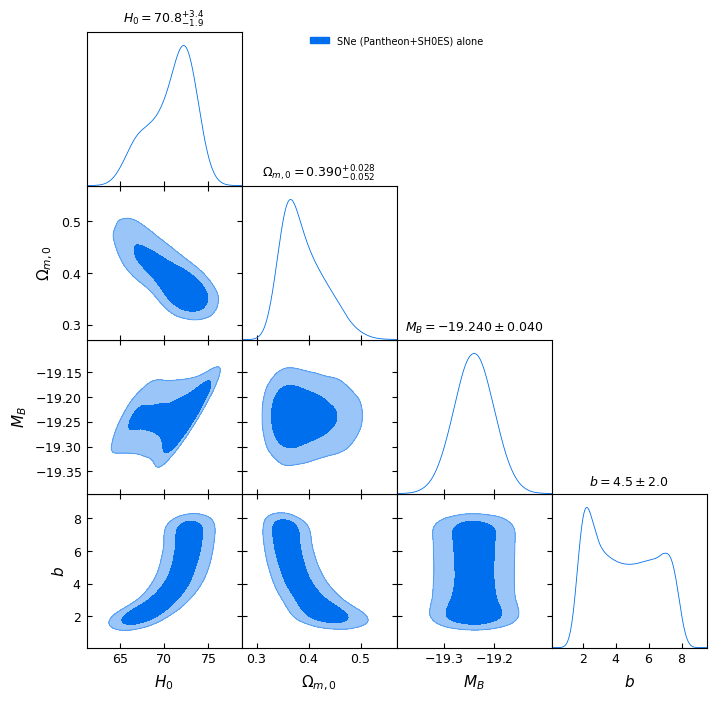

In [11]:
# =========================
# Corner plot using GetDist
# =========================

# Parameter names and LaTeX labels
param_names  = ["H0", "Omega_m0", "MB", "b"]
param_labels = [r"H_0", r"\Omega_{m,0}", r"M_B", r"b"]


# Create GetDist samples object
samples = MCSamples(
    samples=flat_samples,
    names=param_names,
    labels=param_labels
)

# Smoothing and binning settings
samples.updateSettings({
    "smooth_scale_1D": 0.25,
    "smooth_scale_2D": 0.25,
    "fine_bins": 1024,
    "fine_bins_2D": 1024

})


# Parameter ranges (optional)
# samples.setRanges({
#     "param p1": (p1_min, p1_max),
#     "param p2": (p2_min, p2_max),
#     "param p3": (p3_min, p3_max)
# })


# Initialize GetDist subplot plotter
g = plots.get_subplot_plotter()

# Plot styling settings
g.settings.axes_fontsize = 12
g.settings.lab_fontsize = 14
g.settings.legend_fontsize = 10
g.settings.linewidth_contour = 1.2
g.settings.num_plot_contours = 2
g.settings.axis_marker_lw = 1.0
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.3


# Triangle (corner) plot
g.triangle_plot(
    samples,
    filled=True,
    legend_labels=["SNe (Pantheon+SH0ES) alone"],
    #contour_colors=["#"],
    title_limit=1
)

# Save figure
plt.savefig("triangle_AB_sne.png", dpi=300, bbox_inches="tight")
plt.show()